# Atacando un problema de clasificación: predicción de días lluviosos (tercera parte)






# Ingeniería de features

... del inglés *feature engineering*. 

En la jerga de machine learning, las variables (columnas de nuestra matriz X) se denominan *features*. El proceso de *feature engineering* consiste en modificar nuestras features o expandirlas para hacerle el trabajo más fácil al clasificador. Para esto usamos nuestra intuición, por ejemplo, si sabemos que lo importante para un problema de clasificación es el tiempo pasado desde una determinada fecha, entonces podemos referir todos los features temporales en relación a esa fecha. Por supuesto, podría ser que el clasificador *descubriese* por sí mismo esta transformación, pero es más fácil si nos aseguramos de que esté representada claramente en los datos.

Una forma típica de aumentar nuestra cantidad de features es agregar nuevos que representen transformaciones no-lineales de features anteriores. Por ejemplo, nuevos features que sean features viejos al cuadrado, al cubo, etc., o bien productos de pares de viejos features. Este tipo de transformación es precisamente la que permite hacer regresión de polinomios.

Entonces, vamos a avanzar sobre el problema de detectar días lluviosos haciendo un poco de *feature engineering*.

Empezamos como en notebooks anteriores, cargando los datos.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos
from sklearn.metrics import confusion_matrix # matriz de confusion

# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel
d.head() # Mostramos las primeras líneas, para darnos una idea

Mounted at /content/drive


,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_5cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_5cm_Media,Temperatura_Suelo_10cm_Media,Temperatura_Inte_5cm,Temperatura_Intemperie_150cm_Minima,Humedad_Suelo,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Heliofania_Efectiva,Heliofania_Relativa,Tesion_Vapor_Media,Humedad_Media,Humedad_Media_8_14_20,Rocio_Medio,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
0,2018-02-08 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,,NaN,,NaN,NaN,NaN,NaN,NaN
1,2018-02-09 00:00:00.0,23.80764,28.6,20.4,NaN,NaN,NaN,26.21042,NaN,NaN,NaN,11.75,11.75,5.75,NaN,NaN,19.25281,66.0,73.0,16.462780,NaN,1.332639,C,1.665799,C,19.3,NaN,NaN,0.0,-23.904030
2,2018-02-10 00:00:00.0,24.51389,31.7,19.4,NaN,NaN,NaN,26.45972,NaN,NaN,NaN,10.50,0.00,0.00,NaN,NaN,23.28392,72.0,77.0,18.622350,NaN,1.638195,C,2.047743,C,19.0,NaN,NaN,0.0,-23.904030
3,2018-02-11 00:00:00.0,19.50139,24.2,15.1,NaN,NaN,NaN,24.66320,NaN,NaN,NaN,0.00,10.50,4.00,NaN,NaN,14.67725,65.0,67.0,12.071650,NaN,3.247224,E,4.059030,C,20.4,NaN,NaN,0.0,-15.106020
4,2018-02-12 00:00:00.0,16.70625,24.6,9.5,NaN,NaN,NaN,22.63611,NaN,NaN,NaN,0.25,0.00,0.00,NaN,NaN,13.13446,66.0,69.0,9.627476,NaN,1.027778,C,1.284722,C,13.4,NaN,NaN,0.0,-5.394994


Selecciono un subconjunto de columnas, las renombro y me deshago de los datos faltantes.

In [ ]:
d_filtrado = d[['Temperatura_Abrigo_150cm_Maxima',
                'Temperatura_Abrigo_150cm_Minima',
                'Precipitacion_Pluviometrica',
                'Velocidad_Viento_Maxima',
                'Rocio_Medio',
                'Humedad_Media', 'Tesion_Vapor_Media']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename({'Temperatura_Abrigo_150cm_Maxima' : 'temperaturaMaxima',
                   'Temperatura_Abrigo_150cm_Minima' : 'temperaturaMinima',
                   'Precipitacion_Pluviometrica' : 'precipitacion',
                   'Humedad_Media' : 'humedad',
                   'Rocio_Medio' : 'rocio',
                   'Velocidad_Viento_Maxima' : 'viento', 'Tesion_Vapor_Media': 'vapor'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

Creo una nueva columna que contiene la etiqueta que indica si llueve o no llueve.

In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0. 
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    717
1    337
Name: llueveNollueve, dtype: int64

Vuelvo a definir la función necesaria para calcular el balanced accuracy.



In [ ]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

Ahora vamos a usar cinco variables, primero sin ningún tipo de transformación 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Definamos la matriz X
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
print(X.shape) # Como vemos, es una matriz de 1054 filas y 2 columnas
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 



(1054, 5)
El score del modelo es de: 0.6632
Matriz de confusion del modelo es:
[[468 106]
 [249 231]]
Sensibilidad del modelo es de: 0.6855
Especificidad del modelo es de: 0.6527
BA del modelo es de: 0.6691


Pero ahora vamos a empezar a aumentar el espacio de features, primero agregando los términos cuadráticos y cúbicos:

In [ ]:
X_1 = np.concatenate((X, X**2,X**3,X**4, X**5), axis=1)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_1) # encuentro los parametros para el escaleo
X_1 = scaler.transform(X_1) # aplico la transformacion

regLog_1 = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
regLog_1.fit(X_1, y) # Ajustamos el modelo con los parámetros
score = regLog_1.score(X_1,y) # Calculamos el score

ypred = regLog_1.predict(X_1) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 



El score del modelo es de: 0.7068
Matriz de confusion del modelo es:
[[506  98]
 [211 239]]
Sensibilidad del modelo es de: 0.7092
Especificidad del modelo es de: 0.7057
BA del modelo es de: 0.7075


Tenemos que el BA está aparentemente mejorando.

¿Significa que el segundo clasificador tiene mejor performance que el primero?

La respuesta es que sí... pero puede ser por sobreajuste. Entonces, ¿cómo hago para averiguar si efectivamente estoy sobreajustando?

# Train - test split

Una forma de hacer esto es separar parte de los datos para entrenar el modelo (obtener los parámetros) y dejar otra parte para evaluar la performance del modelo. Al hacer eso, tengo las siguientes posibilidades,

*   **La performance es baja en el set de entrenamiento y baja en el set de evaluación.** En este caso, necesito o más datos, o más features (puedo probar agregar features que ya tenía transformándolos).

*   **La performance es alta en el set de entrenamiento y baja en el set de evaluación.** En este caso, estoy sobreajustando. Puedo intentar resolver esto sumando más datos a mi modelo, o bien aplicando regularización.

*   **La performance es alta en el set de entrenamiento y alta en el set de evaluación.** El caso ideal: aprendí parámetros que me sirven para generalizar a datos nuevos sin sobreajustar.

Podemos usar:

```
sklearn.model_selection.train_test_split
```

para separar los datos en partes de entrenamiento y de evaluación, de forma aleatoria.




In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

#### IMPORTANTE: HAGO LA NORMALIZACION DE LOS DATOS POR SEPARADO EN LOS SETS DE TRAIN Y TEST

regLog = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog.score(X_train,y_train) # Calculamos el score
ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_train[2],4))) 
print('\n')

score_test= regLog.score(X_test,y_test) # Calculamos el score
ypred_test= regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_test[2],4))) 


Para TRAIN set:
El score del modelo es de: 0.6608
Matriz de confusion del modelo es:
[[335  73]
 [177 152]]
Sensibilidad del modelo es de: 0.6756
Especificidad del modelo es de: 0.6543
BA del modelo es de: 0.6649


Para TEST set:
El score del modelo es de: 0.7161
Matriz de confusion del modelo es:
[[182  67]
 [ 23  45]]
Sensibilidad del modelo es de: 0.4018
Especificidad del modelo es de: 0.8878
BA del modelo es de: 0.6448


Vemos que en este caso en general tendremos peores performance en el test set (ojo con las fluctuaciones estocasticas por al armar el train-test split)

¿Y si vamos al caso con features polinómicos agregados?

In [ ]:
# Definamos la matriz X
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos

X_temp = X
for i in np.arange(2,5):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp
 


X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

regLog_1 = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=50000) # Inicializamos nuevamente el modelo
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog_1.score(X_train,y_train) # Calculamos el score
ypred_train = regLog_1.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_train[2],4))) 
print('\n')

score_test= regLog_1.score(X_test,y_test) # Calculamos el score
ypred_test= regLog_1.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_test[2],4))) 


Para TRAIN set:
El score del modelo es de: 0.7191
Matriz de confusion del modelo es:
[[358  78]
 [129 172]]
Sensibilidad del modelo es de: 0.688
Especificidad del modelo es de: 0.7351
BA del modelo es de: 0.7116


Para TEST set:
El score del modelo es de: 0.7224
Matriz de confusion del modelo es:
[[229  87]
 [  1   0]]
Sensibilidad del modelo es de: 0.0
Especificidad del modelo es de: 0.9957
BA del modelo es de: 0.4978


Esto es todavia peor en el test set. Señal de que estamos sobreajustando los datos.

Veamos si mejora algo la regularización...

In [ ]:
# Definamos la matriz X
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos


X_temp = X
for i in np.arange(2,5):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp
 

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

regLog_1 = LogisticRegression(penalty = 'l2', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog_1.score(X_train,y_train) # Calculamos el score
ypred_train = regLog_1.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_train[2],4))) 
print('\n')

score_test= regLog_1.score(X_test,y_test) # Calculamos el score
ypred_test= regLog_1.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_test[2],4))) 

Para TRAIN set:
El score del modelo es de: 0.6974
Matriz de confusion del modelo es:
[[356  83]
 [140 158]]
Sensibilidad del modelo es de: 0.6556
Especificidad del modelo es de: 0.7177
BA del modelo es de: 0.6867


Para TEST set:
El score del modelo es de: 0.6246
Matriz de confusion del modelo es:
[[117  15]
 [104  81]]
Sensibilidad del modelo es de: 0.8438
Especificidad del modelo es de: 0.5294
BA del modelo es de: 0.6866


# Optimización de hiperparámetros

Vimos que al sumar regularización, la performance del modelo de repente se ve incrementada en el test set. Posiblemente esto dependa del valor de la constante de penalización C que usamos para la regresión. **Esto es lo que llamamos un hiperparámetro del modelo.** Otro hiperparámetro posible es el grado de la potencia máxima en la que aparecen los features.

Entonces tiene sentido hacer la siguiente pregunta: ¿para qué elección de hiperparámetros **maximizo** la performance del clasificador en el dataset de evaluación (test)?

Vamos a proponer la siguiente forma de abordar este problema:

1.   Generamos una función que entrene y evalue el clasificador usando un train-test split, que incorpore como input los hiperparámetros
2.   Para cada elección del par de hiperparámetros, repetimos este procedimiento unas cuantas (>100) veces y nos quedamos con la performance promedio. Esto es necesario porque el train-test split es aleatorio.
3.   Repetimos para todas las combinaciones de nuestros hiperparámetros y encontramos aquella que maximiza la performance del clasificador.



In [ ]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  X_temp = X
  for i in np.arange(2,n):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
  X = X_temp
 
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=10000) 
  regLog.fit(X_train, y_train) 
  
  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

Probemos algunos casos particulares y veamos como depende del azar,

In [ ]:
 # repitamos varias veces para ver como cambia

campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes


BA_train, BA_test = classifier(X,y,6,1)  
print(BA_train, BA_test)

# aumento C

BA_train, BA_test = classifier(X,y,6,1000)  
print(BA_train, BA_test)

# disminuyo C

BA_train, BA_test = classifier(X,y,6,0.0001)  
print(BA_train, BA_test)


0.6939156161564188 0.6710280373831776
0.7059943401080524 0.6380284824210058
0.6382570101211216 0.6868115942028985


Claramente es difícil sacar conclusiones. Así que vamos a recorrer sistemáticamente los valores de una grilla, replicando muchas veces en cada combinación.


In [ ]:
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

n_values = np.arange(1,7) # rango de potencias maximas 
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 500 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)




[1 2 3 4 5 6]
[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6
 3.8 4.  4.2 4.4 4.6 4.8]
[0, 0]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 5]
[0, 6]
[0, 7]
[0, 8]
[0, 9]
[0, 10]
[0, 11]
[0, 12]
[0, 13]
[0, 14]
[0, 15]
[0, 16]
[0, 17]
[0, 18]
[0, 19]
[0, 20]
[0, 21]
[0, 22]
[0, 23]
[1, 0]
[1, 1]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[1, 6]
[1, 7]
[1, 8]
[1, 9]
[1, 10]
[1, 11]
[1, 12]
[1, 13]
[1, 14]
[1, 15]
[1, 16]
[1, 17]
[1, 18]
[1, 19]
[1, 20]
[1, 21]
[1, 22]
[1, 23]
[2, 0]
[2, 1]
[2, 2]
[2, 3]
[2, 4]
[2, 5]
[2, 6]
[2, 7]
[2, 8]
[2, 9]
[2, 10]
[2, 11]
[2, 12]
[2, 13]
[2, 14]
[2, 15]
[2, 16]
[2, 17]
[2, 18]
[2, 19]
[2, 20]
[2, 21]
[2, 22]
[2, 23]
[3, 0]
[3, 1]
[3, 2]
[3, 3]
[3, 4]
[3, 5]
[3, 6]
[3, 7]
[3, 8]
[3, 9]
[3, 10]
[3, 11]
[3, 12]
[3, 13]
[3, 14]
[3, 15]
[3, 16]
[3, 17]
[3, 18]
[3, 19]
[3, 20]
[3, 21]
[3, 22]
[3, 23]
[4, 0]
[4, 1]
[4, 2]
[4, 3]
[4, 4]
[4, 5]
[4, 6]
[4, 7]
[4, 8]
[4, 9]
[4, 10]
[4, 11]
[4, 12]
[4, 13]
[4, 14]
[4, 15]
[4, 16]
[4, 17]
[4, 18]
[4, 19]
[4, 20]
[

Por último, grafico como me quedan las BA para cada combinación de hiperparametros, y puedo encontrar cual es la BA máxima para cada caso, y con qué hiperparámetros la obtengo.

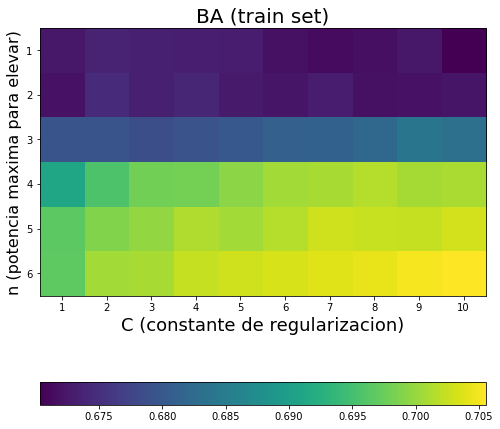

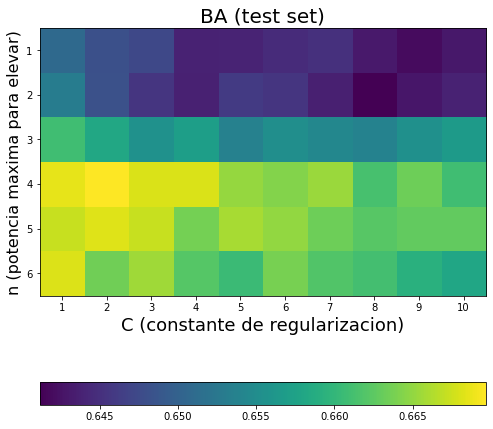

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(8,8))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo 
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(8,8)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)


Vemos entonces que en el caso de train set, como es esperado, aumenta la performance a medida que sumo potencias de grado mayor de los features.

En el caso del test set no es tan simple. Necesito ademas que la constante de regularizacion tenga un valor cercano a 2.

# Para llevarse de este notebook

*   A la hora de evaluar si hay sobreajuste, es clave armar un train-test split, entrenar en el primero y evaluar en el segundo:


```
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
```

Como este split es al azar, se recomienda hacerlo muchas veces y luego promediar las accuracies resultantes para tener una buena idea de la performance del clasificador en ambos grupos.




# Preguntas extra

*   **Estimamos la performance como el máximo de la matriz de balanced accuracies para el test set. Elegimos la combinación de hiperparámetros que resulta en ese máximo. Ahora vamos a aplicar el clasificador a un nuevo subconjunto de datos, y obtenemos una performance peor de lo que esperábamos. ¿Por qué?**
*   Probar agregando otras features, por ejemplo, términos cruzados, y ver cómo cambia la performance. 
*   Esta vez usamos cinco features. ¿Es más mejor? ¿Puedo aumentar la performance si borro features que no son importantes?
*   Si tengo 5 features, en principio hay 2^5 posibles clasificadores usando todos los subconjuntos de features posibles. Claramente, a medida que aumenta la cantidad de features, hacer una evaluacion exhaustiva se vuelve imposible. Este es el problema de *seleccion de features* ¿Se te ocurra alguna idea sobre cómo abordarlo si la cantidad de features es muy grande?

